In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


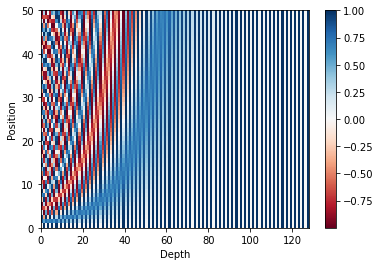

In [3]:
# 50x 128크기를 가지는 포지셔널 인코딩 행렬을 시각화하기
# 입력문자의 단어가 50 각 단어가 128차원의 임베딩 벡터를 가질 때 사용하는 행렬

sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap = "RdBu")
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링 : dk의 루트값으로 나눈다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk /tf.math.sqrt(depth)

    # 마스킹 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weight = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이 , d_model/num_heads)
    output = tf.matmul(attention_weight, value)

    return output, attention_weight

In [5]:
# scaled_dot_product_attention함수가 정상적으로 작동하는지 테스트 !
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                     [0, 0, 10],
                     [0, 0, 10]], dtype=tf.float32) # (4, 3)
temp_v = tf.constant([[  1, 0],
                     [  10, 0],
                     [ 100, 5],
                     [1000, 6]], dtype=tf.float32) # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype = tf.float32) # (1, 3)

In [6]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [7]:
# scaled_dot_product_attention함수가 정상적으로 작동하는지 테스트 !
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                     [0, 0, 10],
                     [0, 0, 10]], dtype=tf.float32) # (4, 3)
temp_v = tf.constant([[  1, 0],
                     [  10, 0],
                     [ 100, 5],
                     [1000, 6]], dtype=tf.float32) # (4, 2)
temp_q = tf.constant([[0, 0, 10]], dtype = tf.float32) # (1, 3)

In [8]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [9]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                     [0, 0, 10],
                     [0, 0, 10]], dtype=tf.float32) # (4, 3)
temp_v = tf.constant([[  1, 0],
                     [  10, 0],
                     [ 100, 5],
                     [1000, 6]], dtype=tf.float32) # (4, 2)
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype = tf.float32) # (1, 3)

In [10]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### 멀티-헤드 어텐션

![](https://wikidocs.net/images/page/31379/transformer17.PNG)

병렬 어텐션의 효과?


머리가 여러개이기 때문에, 여러 시점에서 상대방을 볼 수있다.

1. $W_Q, W_k, W_v$에 해당하는 $d_{model}$크기의 밀집층(Dense layer)을 지남
2. 지정된 헤드 수 (num_heads)만큼 나눈다.
3. 스케일드 닷 프로덕트 어텐션
4. 나눠졌던 헤드들을 연결한다.
5. $W_0$에 해당하는 밀집층을 지나게 된다.

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, attention_weights = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

### 패딩 마스크

![](https://wikidocs.net/images/page/31379/pad_masking2.PNG)

In [31]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [32]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


### 포지션 와이드 피드 포워드 신경망

```
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
outpus = tf.kears.layers.Dense(units=d_model)(outpus)
```

### 인코더 구현하기

In [33]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.layers.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.layers.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더 쌓기

In [34]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.layers.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.layers.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더의 첫번째 서브층 : self 어텐션과 룩-헤드 마스크

- 인코더에 있는 self어텐션 : 패딩마스크전달
- 디코더와 첫번째 서브층인 masked self attention : 룩-어헤드 마스크전달
- 디코더의 두번째 서브층인 인코더-디코더 어텐션 : 패딩마스크전달

In [35]:
# 디코더의 첫번째 서브층에서 미래 토큰을 mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1-tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩 마스크 포함
    return tf.maximum(look_ahead_mask, padding_mask)

In [36]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))


tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 디코더의 두번째 서브층 : 인코더-디코더 어텐션
- 인코더의 첫번째 서브층 : Query = Key = Value
- 디코더의 첫번쨰 서브층 : Query = Key = Value
- 디코더의 두번째 서브층 : Query(디코더행렬) // key= value (인코더행렬)

In [41]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.layers.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.layers.Input(shape=(None, d_model), name="encoder_outputs")

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.layers.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
            'mask': look_ahead_mask # 룩어헤드 마스크
        })

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
            'mask': padding_mask # 패딩 마스크
        })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)
    
    

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [42]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
    inputs = tf.keras.layers.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.layers.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.layers.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 트랜스포머 구현하기 

In [43]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.layers.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.layers.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


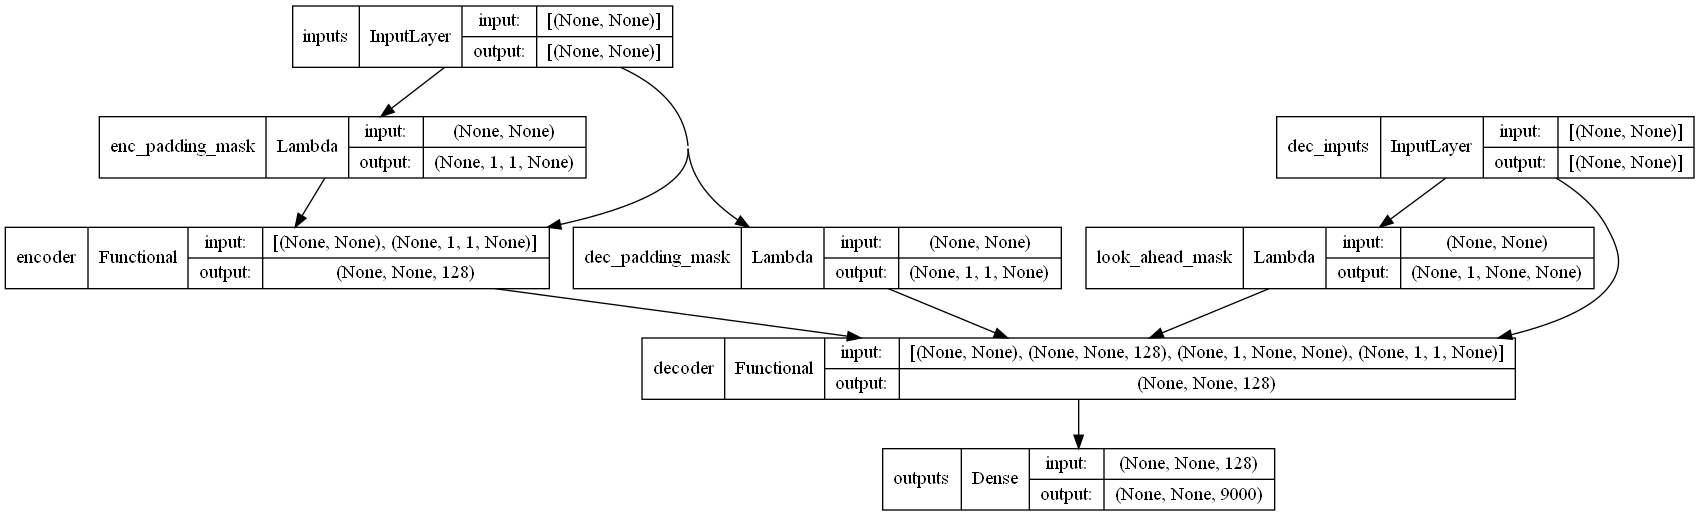

In [44]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name = "small_transformer"
)

tf.keras.utils.plot_model(
    small_transformer, to_file="small_transformer.png", show_shapes=True
)

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, max_length-1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

$$ lr = d_{model}^{-0.5} \times  min(stepnum^{-0.5}, stepnum \times warmupsteps^{-1.5})$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 트랜스포머를 이용한 번역기(영어->한국어)

In [ ]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
from eunjeon import Mecab
mecab = Mecab()

def process_data(path, isKor = False, s_token = False, e_token = False):
    with open(path, "r", encoding='utf8') as f:
        raw = f.read().splitlines()
    output = []
    for sentence in raw:
        # 소문자 변경
        if isKor == False:
            sentence = sentence.lower().strip()

        # 1. 문장 부호를 \1
        sentence = re.sub(r"([?.!,'“”\"])", r" \1 ", sentence)
        # 2. [ ] --> 공백
        sentence = re.sub(r'[" "]+', " ", sentence)
        # 3. 모든 알파벳, 문장기호를 제외한 것들을 공백으로 바꿔주세요.
        if isKor == False:
            sentence = re.sub(r"[^a-zA-Z0-9?!.,'“”\"]+", " ", sentence)
        else:
            sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9?!.,'“”\"]+", " ", sentence)
            sentence = ' '.join(mecab.morphs(sentence))

        sentence = sentence.strip()

        if s_token:
            sentence = '<start> ' + sentence

        if e_token:
            sentence += ' <end>'
        output.append(sentence)
    return output

In [ ]:
eng = process_data('./korean-english-park.train/korean-english-park.train.en')
kor = process_data('./korean-english-park.train/korean-english-park.train.ko', isKor=True)

In [ ]:
len(eng)

In [ ]:
len(kor)

In [ ]:
print(eng[:5])
print(kor[:5])

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    eng + kor, target_vocab_size = 2**13
)

start_token, end_token = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

vocab_size = tokenizer.vocab_size +2

In [ ]:
print('시작 토큰 번호 :', start_token)
print('종료 토큰 번호 :', end_token)
print('단어 집합의 크기 :', vocab_size)

In [ ]:
print('Tokenized sample question: {}'.format(tokenizer.encode(kor[20])))

In [ ]:
# .encode() decode()

sample_string = eng[20]

tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode 정수 -> 텍스트
original_string = tokenizer.decode(tokenized_string)
print('기존 문장: {}'.format(original_string))

In [ ]:
for ts in tokenized_string:
    print('{}--->{}'.format(ts, tokenizer.decode([ts])))

In [ ]:
# .encode() decode()

sample_string = kor[20]

tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode 정수 -> 텍스트
original_string = tokenizer.decode(tokenized_string)
print('기존 문장: {}'.format(original_string))

In [ ]:
for ts in tokenized_string:
    print('{}--->{}'.format(ts, tokenizer.decode([ts])))

In [ ]:
max_length = 40

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # encode (토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
        sentence1 = start_token + tokenizer.encode(sentence1) + end_token
        sentence2 = start_token + tokenizer.encode(sentence2) + end_token

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen = max_length, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=max_length, padding='post'
    )

    return tokenized_inputs, tokenized_outputs

In [ ]:
engs, kors = tokenize_and_filter(eng, kor)

In [ ]:
print('영어 데이터의 크기 (shape) :', engs.shape)
print('한글 데이터의 크기 (shape) :', kors.shape)

In [ ]:
print(engs[0])

print(kors[0])
len(kors[0])

In [ ]:
print('단어 집합의 크기 (VOCAB size): {}'.format(vocab_size))
print('전체 샘플의 수 (Number of samples): {}'.format(len(engs)))

In [ ]:
batch_size = 256
buffer_size = 200000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs' : engs,
        'dec_inputs' : kors[:, :-1] # 디코더의 입력과 마지막 패딩 토큰이 제거
    },
    {
        'outputs': kors[:, 1:] #맨 처음 토큰이 제거된다. 시작토큰 제거
    },
))

In [ ]:
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(engs[0])
print(len(engs[0]))
for ts in engs[0]:
    if 0 < ts < vocab_size - 2:
        print('{}--->{}'.format(ts, tokenizer.decode([ts])))
print(kors[:1][:, :-1]) # 마지막 패딩 토큰이 제거
for ts in kors[:1][:, :-1][0]:
    if 0 < ts < vocab_size - 2:
        print('{}--->{}'.format(ts, tokenizer.decode([ts])))
print(kors[:1][:, 1:]) # 맨 처음 토큰이 제거
for ts in kors[:1][:, 1:][0]:
    if 0 < ts < vocab_size - 2:
        print('{}--->{}'.format(ts, tokenizer.decode([ts])))

In [ ]:
tf.keras.backend.clear_session()

num_layers = 6
d_model = 512
num_heads = 8
dff = 512
dropout = 0.3

model = transformer(
    vocab_size = vocab_size,
    num_layers = num_layers,
    dff = dff,
    d_model = d_model,
    num_heads = num_heads,
    dropout = dropout
)

In [ ]:
max_length = 40
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1 =0.9, beta_2 = 0.98, epsilon=1e-9
)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape = (-1, max_length -1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss = loss_function, metrics = [accuracy])

In [ ]:
epochs = 5

model.fit(dataset, epochs = epochs, validation_data=dataset, validation_freq=1)

In [ ]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(start_token + tokenizer.encode(sentence) + end_token, axis = 0)

    output = tf.expand_dims(start_token, 0)

    # 디코더의 예측 시작
    for i in range(max_length):
        predictions = model(inputs=[sentence, output], training=False)

        # 현재 (마지막) 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if tf.equal(predicted_id, end_token[0]):
            break
        
        # 마지막 시점의 예측 단어를 출력해 연결한다.
        # for문을 통해서 디코더의 입력으로 사용될 예정이다.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )

    print('Input : {}'.format(sentence))
    print('Output : {}'.format(predicted_sentence))

    return predicted_sentence

In [ ]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,'“”\"])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
eng_test = process_data('./korean-english-park.test/korean-english-park.test.en')
kor_test = process_data('./korean-english-park.test/korean-english-park.test.ko', isKor=True)

In [ ]:
import random
nn = random.randrange(0,1999)

output = predict(eng_test[nn])
print('Answer : ', kor_test[nn])

In [ ]:
output = predict("I think there are two in Boston. Which one are you going to?")

In [ ]:
output = predict("Check, please.")